# Определение эмоциональной окраски твитов с помощью BERT

In [8]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 296 (delta 0), reused 1 (delta 0), pack-reused 293 (from 1)
Receiving objects: 100% (296/296), 42.30 MiB | 10.52 MiB/s, done.
Resolving deltas: 100% (134/134), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.8/936.8 kB 

## Установка библиотек

In [2]:
!pip install pytorch-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 9.1 MB/s eta 0:00:00


In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [10]:
import pandas as pd

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
pos_texts = pd.read_csv('/content/positive (2).csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('/content/negative.csv', encoding='utf8', sep=';', header=None)

In [12]:
pos_texts.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [14]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])


sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]


In [15]:
assert len(sentences) == len(labels) == pos_texts.shape[0] + neg_texts.shape[0]

In [ ]:
print(sentences[1000])

In [41]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences[:10000], labels[:10000], test_size=0.3)

In [ ]:
print(len(train_gt), len(test_gt))

## Inputs

In [42]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])
tokenized_texts = tokenized_texts

['[CLS]', '@', 'anderson', '##and', '##ree', '##v', 'в', '##л', '##ю', '##б', '##л', '##я', '##е', '##ш', '##ь', '##с', '##я', 'а', '##в', '##т', '##о', '##м', '##а', '##т', '##и', '##ч', '##е', '##с', '##к', '##и', '?', ')', 'к', '##л', '##а', '##с', '##с', '##н', '##ы', '##е', 'с', '##л', '##ов', '##а', ')', '[SEP]']



- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [43]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [44]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt,
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [45]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [46]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [47]:
train_labels

tensor([[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]])

In [48]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=32
)

In [49]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=32
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [50]:
from pytorch_transformers import AdamW, BertForSequenceClassification

In [51]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

/usr/local/lib/python3.10/dist-packages/pytorch_transformers/modeling_utils.py:539: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_fi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [52]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



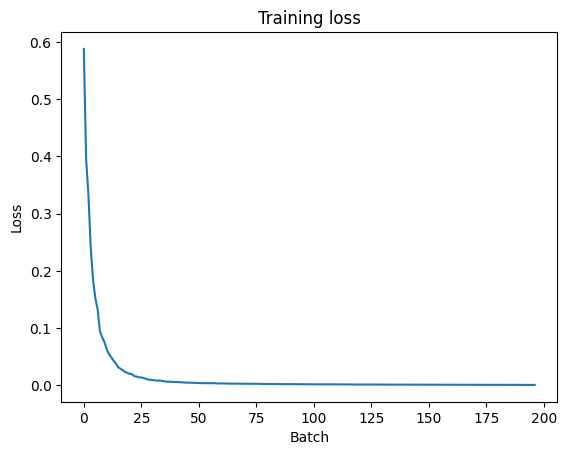

100%|██████████| 197/197 [02:27<00:00,  1.33it/s]


Loss на обучающей выборке: 0.01600
Процент правильных предсказаний на валидационной выборке: 100.00%


In [54]:
from IPython.display import clear_output
from tqdm import tqdm

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(tqdm(train_dataloader)):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()

    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())

    # Backward pass
    loss[0].backward()

    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()

    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [55]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 100.00%


# Оценка качества на отложенной выборке

In [56]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

In [57]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data,
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [59]:
model.eval()
test_preds, test_labels = [], []

for batch in tqdm(prediction_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

100%|██████████| 94/94 [00:19<00:00,  4.88it/s]


In [60]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 100.00%
